# Objective
Predict whether a person contracted Covid, Pneumonia or neither given their x-rays images of lungs
## Data
The data contains x-rays images for 3616 people diagnosed with Covid, 1345 people diagnosed with pneumonia, and 10192 normal people without Covid or Pneumonia

With such a model, it potentially helps:
- Early detection and treatment: A predictive model could help in the early detection of COVID-19, pneumonia, and other respiratory illnesses, allowing for prompt treatment and preventing the spread of disease.
- Screening precision: A predictive model with goog predictive power can be used for screening purposes to identify individuals who may have COVID-19 or pneumonia and require further evaluation.
- Misdiagnosis reduction: A predictive model with goog predictive power can add to the disagnosis toolkit that help differentiate between COVID-19 and other respiratory illnesses, such as pneumonia, which could lead to better disease management and outcomes

At the same time, multiple groups of individuals could potentially be benefited by it:
- Healthcare providers could be assited in making more accurate diagnoses and treatment decisions
- Patients with such illness could be detected and treated on the timely basis
- Researchers could use it to study population with Covid or Pneumonia against normal population to optimize future prevention and treatment strategies




In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/Colab\ Notebooks/Adv\ ML/covid_radiography_data/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


# Data Loading & Preprocessing

In [5]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
# print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [6]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
len(image_filepaths)
# image_filepaths

4032

In [10]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [11]:
len(fnames[2])

1344

In [12]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import ImageGrid
# import numpy as np
# import random

# im1 =preprocessor(fnames[0][0])
# im2 =preprocessor(fnames[0][1])
# im3 =preprocessor(fnames[1][1])
# im4 =preprocessor(fnames[1][1])

# fig = plt.figure(figsize=(4., 4.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(2, 2),  # creates 2x2 grid of axes
#                  axes_pad=0.25,  # pad between axes in inch.
#                  )

# for ax, im in zip(grid, [im1, im2, im3, im4]):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im)
# plt.show()

### Visualize images when x-rays demonstrate Covid Positivity (COVID) and when they do not (NORMAL or PNEUMONIA)

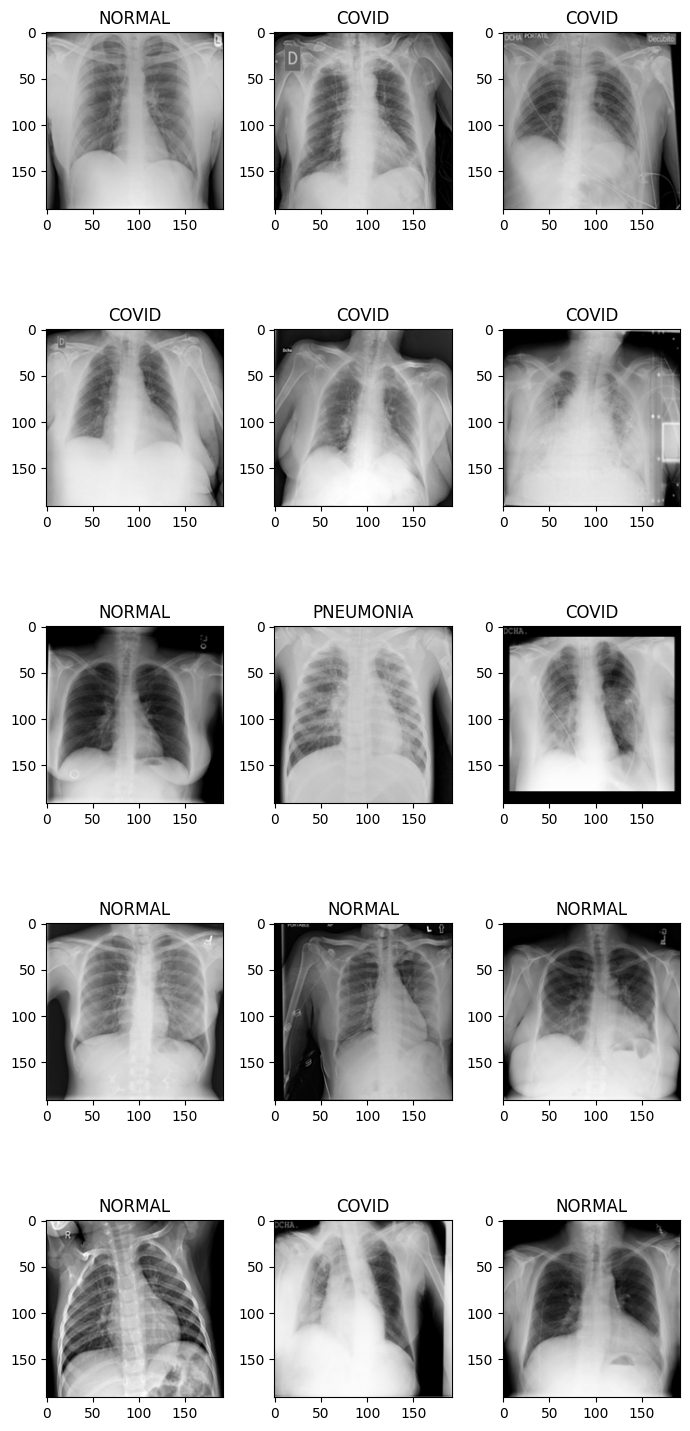

In [13]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range(3):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(y_labels[l])
        
plt.tight_layout()

In [14]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)


# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)


# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(y_test, file)

with open('filepaths.pkl', 'wb') as file:
    pickle.dump(image_filepaths, file)

with open('y_labels.pkl', 'wb') as file:
    pickle.dump(y_labels, file)

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


## Data Extraction

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

# Modeling

## VGG16

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
            
  mc = ModelCheckpoint('best_model_VGG.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
  
  # Fitting the CNN to the Training set
  model_hist = model.fit(X_train, y_train, epochs = 20, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.0977 - acc: 0.3618
Epoch 00001: val_acc improved from -inf to 0.34973, saving model to best_model_VGG.h5
69/69 [==============================] - 9s 116ms/step - loss: 1.0977 - acc: 0.3618 - val_loss: 1.0968 - val_acc: 0.3497 - lr: 0.0100
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 1.0960 - acc: 0.4594
Epoch 00002: val_acc improved from 0.34973 to 0.69217, saving model to best_model_VGG.h5
69/69 [==============================] - 7s 101ms/step - loss: 1.0960 - acc: 0.4594 - val_loss: 1.0950 - val_acc: 0.6922 - lr: 0.0100
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 1.0939 - acc: 0.5734
Epoch 00003: val_acc did not improve from 0.69217
69/69 [==============================] - 7s 102ms/step - loss: 1.0939 - acc: 0.5734 - val_loss: 1.0928 - val_acc: 0.5264 - lr: 0.0100
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 1.0905 - acc: 0.5525
Epoch 00004: val_

In [ ]:
# def epoch_loss(history):
#   # Plot training loss and validation loss over a range of epoch
#   import matplotlib.pyplot as plt
#   import numpy as np
#   # Get training and validation loss histories
#   training_loss = history.history['loss']
#   val_loss = history.history['val_loss']

#   # Create count of the number of epochs
#   epoch_count = range(1, len(training_loss) + 1)

#   # Visualize loss history
#   plt.plot(epoch_count, training_loss, 'r--')
#   plt.plot(epoch_count, val_loss, 'b-')
#   plt.legend(['Training Loss', 'Validation Loss'])
#   plt.xlabel('Epoch')
#   plt.ylabel('Loss')
#   plt.show();

#   # I have ran this to help determine the optimized epoch being 5
#   print(epoch_count[val_loss.index(min(val_loss))])

In [ ]:
# epoch_loss(model_hist)

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.0025, 0.0025, 0.00125, 0.00125]
10


In [ ]:
# model.save("model1.h5", save_format="h5")
del(model)

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('best_model_VGG.h5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                 

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

def y_pred(model):
  #Load preprocessed data
  #If you run out of Colab memory restart runtime, reload data and try again
  import pickle
    
  # Open the file in binary mode
  with open('X_test.pkl', 'rb') as file:
      # Call load method to deserialze
      X_test = pickle.load(file)

  # Open the file in binary mode
  with open('y_test.pkl', 'rb') as file:
      # Call load method to deserialze
      y_test = pickle.load(file)
      
  prediction_column_index=model.predict(X_test).argmax(axis=1)

  # extract correct prediction labels 
  prediction_labels = [y_test.columns[i] for i in prediction_column_index]
  return prediction_labels

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 2s 36ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 69

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
# #Submit Model with predictions only (if you cannot save an onnx file): 

# #-- Generate predicted y values (Model 1)
# #Note: Keras predict returns the predicted column index location for classification models
# prediction_column_index=model.predict(X_test).argmax(axis=1)

# # extract correct prediction labels 
# prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# # Submit Model 1 to Competition Leaderboard
# experiment.submit_model(model_filepath = None,
#                                  preprocessor_filepath=None,
#                                  prediction_submission=prediction_labels)

### Performance
Accuracy: 0.7118512781   
F1-score: 0.6986914698  
Precison: 0.7321578276  
Recall: 0.7117178367

Out of the first three model I tried, VGG, Squeezenet and VGG16 with transafer learning, the performance of VGG performs poorly

## VGG16 with batch normalization

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
            
  mc = ModelCheckpoint('best_model_VGG_norm.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, epochs = 20, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 3.5209 - acc: 0.7728
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model_VGG_norm.h5
69/69 [==============================] - 12s 128ms/step - loss: 3.5209 - acc: 0.7728 - val_loss: 5.3065 - val_acc: 0.3406 - lr: 0.0010
Epoch 2/20
68/69 [============================>.] - ETA: 0s - loss: 1.7493 - acc: 0.8635
Epoch 00002: val_acc did not improve from 0.34062
69/69 [==============================] - 7s 101ms/step - loss: 1.7428 - acc: 0.8627 - val_loss: 8.2931 - val_acc: 0.3206 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 1.4374 - acc: 0.8901
Epoch 00003: val_acc improved from 0.34062 to 0.55920, saving model to best_model_VGG_norm.h5
69/69 [==============================] - 7s 99ms/step - loss: 1.4374 - acc: 0.8901 - val_loss: 4.9975 - val_acc: 0.5592 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 1.3657 - acc: 0.8964
Epoch 0

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
9


In [ ]:
# model.save("squeezenet2.h5", save_format="h5")
del(model)

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('best_model_VGG_norm.h5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_95 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization_94 (Bat  (None, 192, 192, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_97 (Conv2D)          (None, 96, 96, 64)        4

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model7.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 2s 38ms/step


In [ ]:
experiment.submit_model(model_filepath = "model7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 237

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Performance
Accuracy: 0.894655306   
F1-score: 0.8945453303  
Precison: 0.897898333  
Recall: 0.8946222054

Given that batch normalization helps and VGG seems to perform the best in the transfer learning section, I tried the combination of similar structure of VGG and batch normalization, which lead to my best model so far, having the highest accuracy, F1-score, precision and recall score. 

## Squeezenet

In [ ]:
l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

In [ ]:
# Run model

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)

            from tensorflow.python.keras.callbacks import ReduceLROnPlateau
            from tensorflow.python.keras.callbacks import ModelCheckpoint
            
            mc = ModelCheckpoint('best_model_squeezenet.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
            red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
        
            model_hist = model.fit(X_train, y_train, epochs = 20, verbose=1, validation_split=.2, callbacks=[mc,red_lr])


Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 1.0985 - acc: 0.3303
Epoch 00001: val_acc improved from -inf to 0.32058, saving model to best_model_squeezenet.h5
69/69 [==============================] - 12s 142ms/step - loss: 1.0985 - acc: 0.3303 - val_loss: 1.0990 - val_acc: 0.3206 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 1.0874 - acc: 0.3609
Epoch 00002: val_acc improved from 0.32058 to 0.44080, saving model to best_model_squeezenet.h5
69/69 [==============================] - 7s 100ms/step - loss: 1.0874 - acc: 0.3609 - val_loss: 1.0825 - val_acc: 0.4408 - lr: 0.0010
Epoch 3/20
68/69 [============================>.] - ETA: 0s - loss: 1.0658 - acc: 0.4577
Epoch 00003: val_acc improved from 0.44080 to 0.45719, saving model to best_model_squeezenet.h5
69/69 [==============================] - 7s 96ms/step - loss: 1.0659 - acc: 0.4567 - val_loss: 1.0447 - val_acc: 0.4572 - lr: 0.0010
Epoch 4/20
69/69 [============================

In [ ]:
# epoch_loss(model_hist)

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
17


In [ ]:
# # Export the model
# model.save("squeezenet.h5", save_format="h5")
del(model)

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('best_model_squeezenet.h5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 192, 192, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 192, 192, 24  792         ['conv2d_40[0][0]']              
                                )                                                             

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 3s 53ms/step


In [ ]:
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 71

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Performance
Accuracy: 0.7118512781   
F1-score: 0.6986914698  
Precison: 0.7321578276  
Recall: 0.7117178367

Out of the first three model I tried, VGG, Squeezenet and VGG16 with transafer learning, the performance of Squeezenet performs poorly

## Squezzenet with batch normalization

In [ ]:
# Adding batch normalization to assist with optimization for deeper network

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192,3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
            
  mc = ModelCheckpoint('best_model_squeezenet2.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, epochs = 20, verbose=1, validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 0.5478 - acc: 0.7619
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model_squeezenet2.h5
69/69 [==============================] - 16s 199ms/step - loss: 0.5478 - acc: 0.7619 - val_loss: 2.4002 - val_acc: 0.3406 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.3503 - acc: 0.8650
Epoch 00002: val_acc did not improve from 0.34062
69/69 [==============================] - 11s 156ms/step - loss: 0.3503 - acc: 0.8650 - val_loss: 4.2283 - val_acc: 0.3406 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.2314 - acc: 0.9101
Epoch 00003: val_acc did not improve from 0.34062
69/69 [==============================] - 11s 163ms/step - loss: 0.2314 - acc: 0.9101 - val_loss: 4.8426 - val_acc: 0.3406 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.2014 - acc: 0.9293
Epoch 00004: val_acc did not improve from 0.3

In [ ]:
# epoch_loss(model_hist)

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
14


In [ ]:
# model.save("squeezenet2.h5", save_format="h5")
del(model)

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('best_model_squeezenet2.h5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 192, 192, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 192, 192, 32  128        ['conv2d_66[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 3s 54ms/step


In [ ]:
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 74

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Performance
Accuracy: 0.7219209915   
F1-score: 0.7200185046  
Precison: 0.7217238789  
Recall: 0.7217827659

This is my approach to improve the generalization power for Squezzenet which slightly improve the prediction performance

## Transfer Learning

Transfer Learning starts with pre-established weights and retrain model final output layer to fit new output layer parameters to your data
Different ways we might use a pretrained model:

1. The pre-trained model is used directly to classify new images.
2. The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training.
3. Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model. Takes more computational power b/c we are fitting complete model (i.e.-VGGNet has lots of parameters to train!)

In [ ]:
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                   include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                   weights='imagenet') 

# Freeze the weights of the VGG16 model so that they are not trained when you fit the model
base_model.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                            

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 20, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
2192/2192 [==============================] - ETA: 0s - loss: 1.1237 - acc: 0.3394
Epoch 00001: val_acc improved from -inf to 0.33880, saving model to best_model.h5
2192/2192 [==============================] - 28s 12ms/step - loss: 1.1237 - acc: 0.3394 - val_loss: 1.0985 - val_acc: 0.3388 - lr: 0.0100
Epoch 2/10
2189/2192 [============================>.] - ETA: 0s - loss: 1.1008 - acc: 0.3321
Epoch 00002: val_acc did not improve from 0.33880
2192/2192 [==============================] - 35s 16ms/step - loss: 1.1007 - acc: 0.3326 - val_loss: 1.1006 - val_acc: 0.3388 - lr: 0.0100
Epoch 3/10
2190/2192 [============================>.] - ETA: 0s - loss: 1.1009 - acc: 0.3196
Epoch 00003: val_acc did not improve from 0.33880

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 27s 12ms/step - loss: 1.1009 - acc: 0.3193 - val_loss: 1.1004 - val_acc: 0.3206 - lr: 0.0100
Epoch 4/10
2190/2192 [=======================

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.00125]
5


In [ ]:
del(model)

In [ ]:
model = tf.keras.models.load_model('best_model.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

In [ ]:
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

#### Performance

Accuracy: 0.8938807126   
F1-score: 0.8940420001  
Precison: 0.9023715257  
Recall: 0.8938739905

Out of all the models with transfer learning, VGG16 outperforms others with the highest accuracy, f1-score, precison and recall score. VGG16 also outperforms other models without transfer learning except the VGG structure with batch normalization.

### ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model_resnet.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 20, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
17


In [ ]:
del(model)

In [ ]:
model = tf.keras.models.load_model('best_model_resnet.h5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 5s 79ms/step


In [ ]:
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 233

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


#### Performance

Accuracy: 0.7033307514   
F1-score: 0.6893731912  
Precison: 0.7191107949  
Recall: 0.7031961006

Since transfer learning helps improve the model performance, I tried some more models with transfer learning. Unfortunately, this model performs the worst to this point and I am afraid that may be caused by overfitting

### Inception

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model_inception.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 20, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/20
2192/2192 [==============================] - ETA: 0s - loss: 0.8629 - acc: 0.7099
Epoch 00001: val_acc improved from -inf to 0.74135, saving model to best_model_inception.h5
2192/2192 [==============================] - 138s 58ms/step - loss: 0.8629 - acc: 0.7099 - val_loss: 0.8124 - val_acc: 0.7413 - lr: 0.0010
Epoch 2/20
2192/2192 [==============================] - ETA: 0s - loss: 0.7863 - acc: 0.7523
Epoch 00002: val_acc improved from 0.74135 to 0.74863, saving model to best_model_inception.h5
2192/2192 [==============================] - 111s 50ms/step - loss: 0.7863 - acc: 0.7523 - val_loss: 0.6990 - val_acc: 0.7486 - lr: 0.0010
Epoch 3/20
2192/2192 [==============================] - ETA: 0s - loss: 0.6015 - acc: 0.7929
Epoch 00003: val_acc improved from 0.74863 to 0.76321, saving model to best_model_inception.h5
2192/2192 [==============================] - 107s 49ms/step - loss: 0.6015 - acc: 0.7929 - val_loss: 0.6383 - val_acc: 0.7632 - lr: 0.0010
Epoch 4/20
2192/2192 [

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
16


In [ ]:
del(model)

In [ ]:
model = tf.keras.models.load_model('best_model_inception.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
prediction_labels = y_pred(model)

41/41 [==============================] - 6s 75ms/step


In [ ]:
experiment.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 234

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


#### Performance

Accuracy: 0.8458559256   
F1-score: 0.8443286681  
Precison: 0.8451673356  
Recall: 0.8457831975

Compared to other models, Inception model with transfer learning performs fairly well, slightly worse than the VGG16 with transfer learning

## Data Augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
with open('filepaths.pkl', 'rb') as file:
    # Call load method to deserialze
    filenamelist = pickle.load(file)

with open('y_labels.pkl', 'rb') as file:
    # Call load method to deserialze
    y_labels = pickle.load(file)

# print(filenamelist)
# print(y_labels)

['COVID-19_Radiography_Dataset/COVID/images/COVID-1960.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-904.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2435.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-787.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1257.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3379.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-819.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1690.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1338.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3508.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1990.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-617.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3309.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2410.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1926.png', 'COVID-19_Radiography_Dataset/COVID/images/

In [ ]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

# same split ratio and same random seed as above
X_train_datagen, X_test_datagen, y_train_datagen, y_test_datagen = train_test_split(filenamelist, y_labels, test_size = 0.32, random_state = 1987)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Normal/images/Normal-3766.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-380.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-289.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2510.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2267.png']


['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'COVID']

In [ ]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

,X,y
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
1,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
2,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True) 
# width_shift_range=.15,
# height_shift_range=.15,

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192,192),
        batch_size=1,
        class_mode='categorical',shuffle=True)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192,192),
        batch_size=1,
        class_mode='categorical')

Found 2741 validated image filenames belonging to 3 classes.
Found 1291 validated image filenames belonging to 3 classes.


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
            
  mc = ModelCheckpoint('best_model_VGG_augmented.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  
  # Fitting the CNN to the Training set
  # model.fit(X_train, y_train, epochs = 20, verbose=1, validation_split=.2, callbacks=[mc,red_lr])

  # fits the model on batches with real-time data augmentation:
  model.fit(train_generator,
            steps_per_epoch=len(trainingdata) / 1, epochs = 20, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
            validation_data=validation_generator, callbacks=[mc,red_lr])

Epoch 1/20
2739/2741 [============================>.] - ETA: 0s - loss: 23.9286 - acc: 0.5199
Epoch 00001: val_acc improved from -inf to 0.46476, saving model to best_model_VGG_augmented.h5
2741/2741 [==============================] - 71s 26ms/step - loss: 23.9287 - acc: 0.5199 - val_loss: 23.5407 - val_acc: 0.4648 - lr: 0.0010
Epoch 2/20
2740/2741 [============================>.] - ETA: 0s - loss: 8.4124 - acc: 0.5807
Epoch 00002: val_acc improved from 0.46476 to 0.50503, saving model to best_model_VGG_augmented.h5
2741/2741 [==============================] - 70s 26ms/step - loss: 8.4160 - acc: 0.5804 - val_loss: 3.5396 - val_acc: 0.5050 - lr: 0.0010
Epoch 3/20
2740/2741 [============================>.] - ETA: 0s - loss: 1.8287 - acc: 0.6186
Epoch 00003: val_acc improved from 0.50503 to 0.60418, saving model to best_model_VGG_augmented.h5
2741/2741 [==============================] - 63s 23ms/step - loss: 1.8283 - acc: 0.6184 - val_loss: 1.2646 - val_acc: 0.6042 - lr: 0.0010
Epoch 4/20

In [ ]:
del(model)

In [ ]:
model = tf.keras.models.load_model('best_model_VGG_augmented.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 192, 192, 32)      896       
                                                                 
 conv2d_119 (Conv2D)         (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization_106 (Ba  (None, 192, 192, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 96, 96, 64)        18496     
                                                                 
 conv2d_121 (Conv2D)         (None, 96, 96, 64)       

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model_8.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Submit Model

# extract correct prediction labels 
prediction_labels = y_pred(model)

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model_8.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

41/41 [==============================] - 1s 29ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 246

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


# Best Performer

VGG structure with batch normalization performs the best out of all my model choices

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('best_model_VGG_norm.h5',compile=False)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_95 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization_94 (Bat  (None, 192, 192, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_97 (Conv2D)          (None, 96, 96, 64)        4